In [16]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import numpy as np

In [27]:
images_dir = "training/"
labels = pd.read_csv("training_labels.csv")

# add the directory to the filename
labels['ID'] = labels['ID'].apply(lambda x: os.path.join(images_dir, x))

# Initialize the ImageDataGenerator
# You can change the size of the validation split (0.25 is 25% of data used as validation set)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

# Create the training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=None,  
    x_col='ID',
    y_col='target',
    target_size=(224, 224), # You can change the size of the image
    batch_size=32, # You can change the batch_size
    class_mode='categorical',  
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=None,  
    x_col='ID',
    y_col='target',
    target_size=(224, 224), # Should match training size
    batch_size=32, # Should match training
    class_mode='categorical',  
    subset='validation'
)

Found 2591 validated image filenames belonging to 5 classes.
Found 863 validated image filenames belonging to 5 classes.


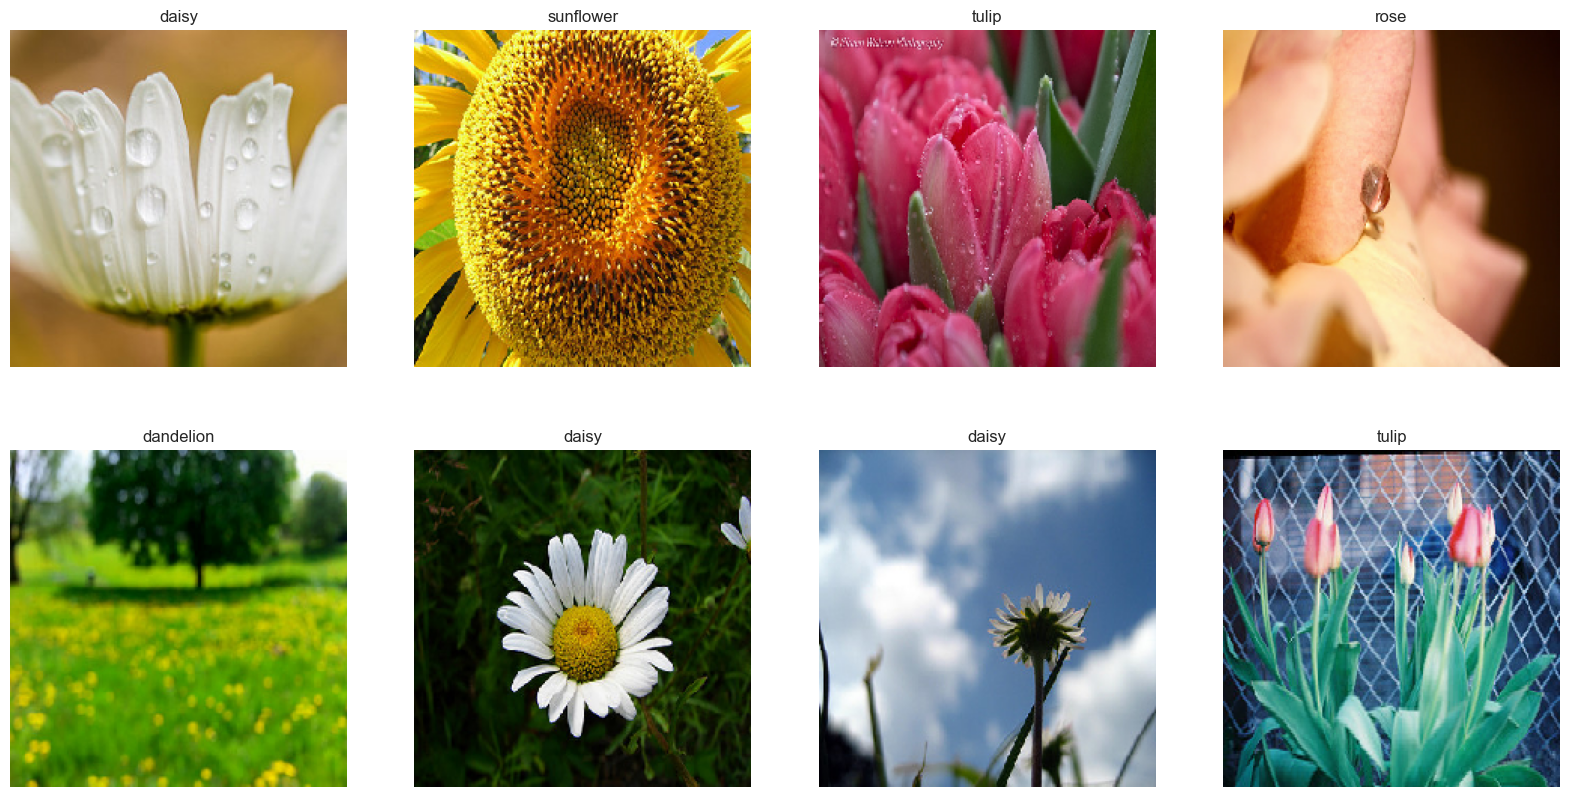

In [24]:
## Plot a few of the images
import matplotlib.pyplot as plt

# Fetch a batch of images and their labels
images, labels = next(train_generator)

# Number of images to show
num_images = 8

plt.figure(figsize=(20, 10))
for i in range(num_images):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    # The label for current image
    label_index = labels[i].argmax()  # Convert one-hot encoding to index
    label = list(train_generator.class_indices.keys())[label_index]  # Get label name from index
    plt.title(label)
    plt.axis('off')
plt.show()


In [29]:
base_mod = ResNet50(weights='imagenet')

# Freeze the base model layers
for layer in base_mod.layers:
    layer.trainable = False

# Create the model
model = Sequential([
    base_mod,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels['target'].unique()), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs as necessary
)

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.2405 - loss: 1.6055 - val_accuracy: 0.2422 - val_loss: 1.5999
Epoch 2/20
35/81 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.2477 - loss: 1.5995

KeyboardInterrupt: 

In [28]:
preds = model.predict()

,ID,target
0,training/kzUfFo77KgG06mSS.jpg,tulip
1,training/d0S5xHpUrzjpJVb6.jpg,sunflower
2,training/gvK7DJST0djANZSN.jpg,tulip
3,training/T3ohrkgqPiq0cDs8.jpg,tulip
4,training/bFLvatoL6CNBzLHd.jpg,daisy
